# Stock Price Predictor - Final Project Notebook
#### Kevin Jin, Ho Hin Lee, Tiancheng Li, Yuchen Li

### Problem Statement
- Stock prices are volatile and fluctuate daily
- Quantitative trading strategies are utilized by many financial institutions to develop trading strategies
- Project aims to use machine learning models to develop a simple web app that predicts future prices for the end-user to form a trading strategy

### Algorithm

- Tested ARIMA, Recurrent Neural Network (LSTM), and Random Forest Models
- Used 1 test stock (AAPL) dataset from January 1, 2017 to May 1, 2018 data
- Evaluated models using RMSE


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
%matplotlib inline
import math
import time
import datetime

import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
from pandas import datetime
from pandas_datareader import data

stock = 'AAPL'
start = datetime(2016,3,19)
end = datetime(2018,5,1)

df = data.DataReader(stock, 'iex', start, end)

y = df['close']
y1 = y.iloc[1:]
y1 = (np.append(y1,[0]))
y2 = y.iloc[5:]
y2 = (np.append(y2,[0,0,0,0,0]))
df['price+1'] = y1 #future price
df['price+5'] = y2

df.head()

5y


,open,high,low,close,volume,price+1,price+5
date,,,,,,,
2016-03-21,102.1213,103.7794,101.3598,102.1020,35502678,102.8829,103.8084
2016-03-22,101.4657,103.4324,101.4272,102.8829,32444375,102.3141,105.6208
2016-03-23,102.6515,103.2203,102.0924,102.3141,25703495,101.8706,105.0713
2016-03-24,101.6778,102.4298,101.1187,101.8706,26132955,101.4079,106.0353
2016-03-28,102.1888,102.3719,101.2826,101.4079,19411372,103.8084,107.1247


D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,close,volume,price+1,price+5,macd,rsi_12,volume_delta,MA 20,MA 50,Daily Change,Range
date,,,,,,,,,,,
2017-01-03,113.8474,28781865,113.7200,116.7488,1.277287,52.196938,-1804400.0,112.612895,110.465704,0.3430,1.368094
2017-01-04,113.7200,21118116,114.2983,117.3761,1.188925,49.671961,-7663749.0,112.951545,110.466010,0.1666,0.656558
2017-01-05,114.2983,22193587,115.5725,116.8860,1.152279,60.167694,1075471.0,113.277945,110.457402,0.6763,0.910283
2017-01-06,115.5725,31751900,116.6311,116.6801,1.212082,74.324962,9558313.0,113.615125,110.462576,1.1076,1.451020
2017-01-09,116.6311,33561948,116.7488,117.6211,1.329570,81.042392,1810048.0,113.951815,110.540802,1.0193,1.263300


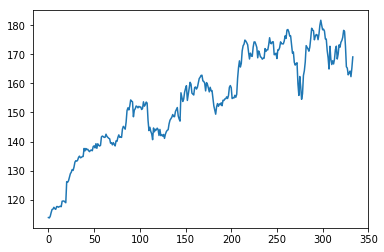

In [3]:
from stockstats import StockDataFrame
df = StockDataFrame.retype(df)
y = df['close']

#generate features with stockstats package
df['macd'] = df.get('macd')
df['rsi_12'] = df.get('rsi_6')
df['volume_delta'] = df.get('volume_delta')
df['MA 20'] = y.rolling(20).mean()
df['MA 50'] = y.rolling(50).mean()
df['Daily Change'] = df['close']-df['open']
df['Range'] = ((df['high']-df['low'])/df['low'])*100
df.tail(10)
df = pd.DataFrame(df)

X = df.drop(['open', 'high', 'low', 'macdh', 'macds', 'close_-1_s', 'close_-1_d', 'rs_6', 'rsi_6', 'close_12_ema', 'close_26_ema'], axis=1)
X_shape = X.shape[0]
X1 = X['20160103':]
y = X1['close']
y_max = np.max(np.array(y))
y_min = np.min(np.array(y))
plt.plot(np.array(y))
X1.head()



 - In the cell above, there are several technical indicators added to the pandas dataframe using the StockStats package. Aside from the closing price and volume, the remaining data from the initial dataset is not used for the machine learning model except to calculate Daily Change and Fluctuation (Range). These include indicators like Moving average convergence divergence(MACD), Relative Strength Index (RSI), Moving Averages, and changes over time.
 
 
 
 
 - Mathematically, these are described as follows:
 
 
 
 
 
- Moving Averages for $n = 20$ and $n=50$: 
 $$\text{Moving Averages} = \frac{P_t + P_{t+1} + ... + P_{t-(n-1)}}{n}$$
 
 
 
- Daily Change:
 $$\text{Daily Change} = Close - Open$$



- Range:
$$Range = High-Low$$




- MACD using 12 and 26 days Exponential Moving Averages (EMA):
 $$\text{MACD} = EMA_{n=12}-EMA_{n=26}$$
 



- RSI for $n=12$:
 $$\text{RSI} = 100-\frac{100}{1+\frac{\text{Sum of gains from past n}}{\text{Sum of losses from past n}}}$$
 


- Volume Delta:
$$\text{Volumn Delta} = Volume_{n}-Volume_{n-1}$$


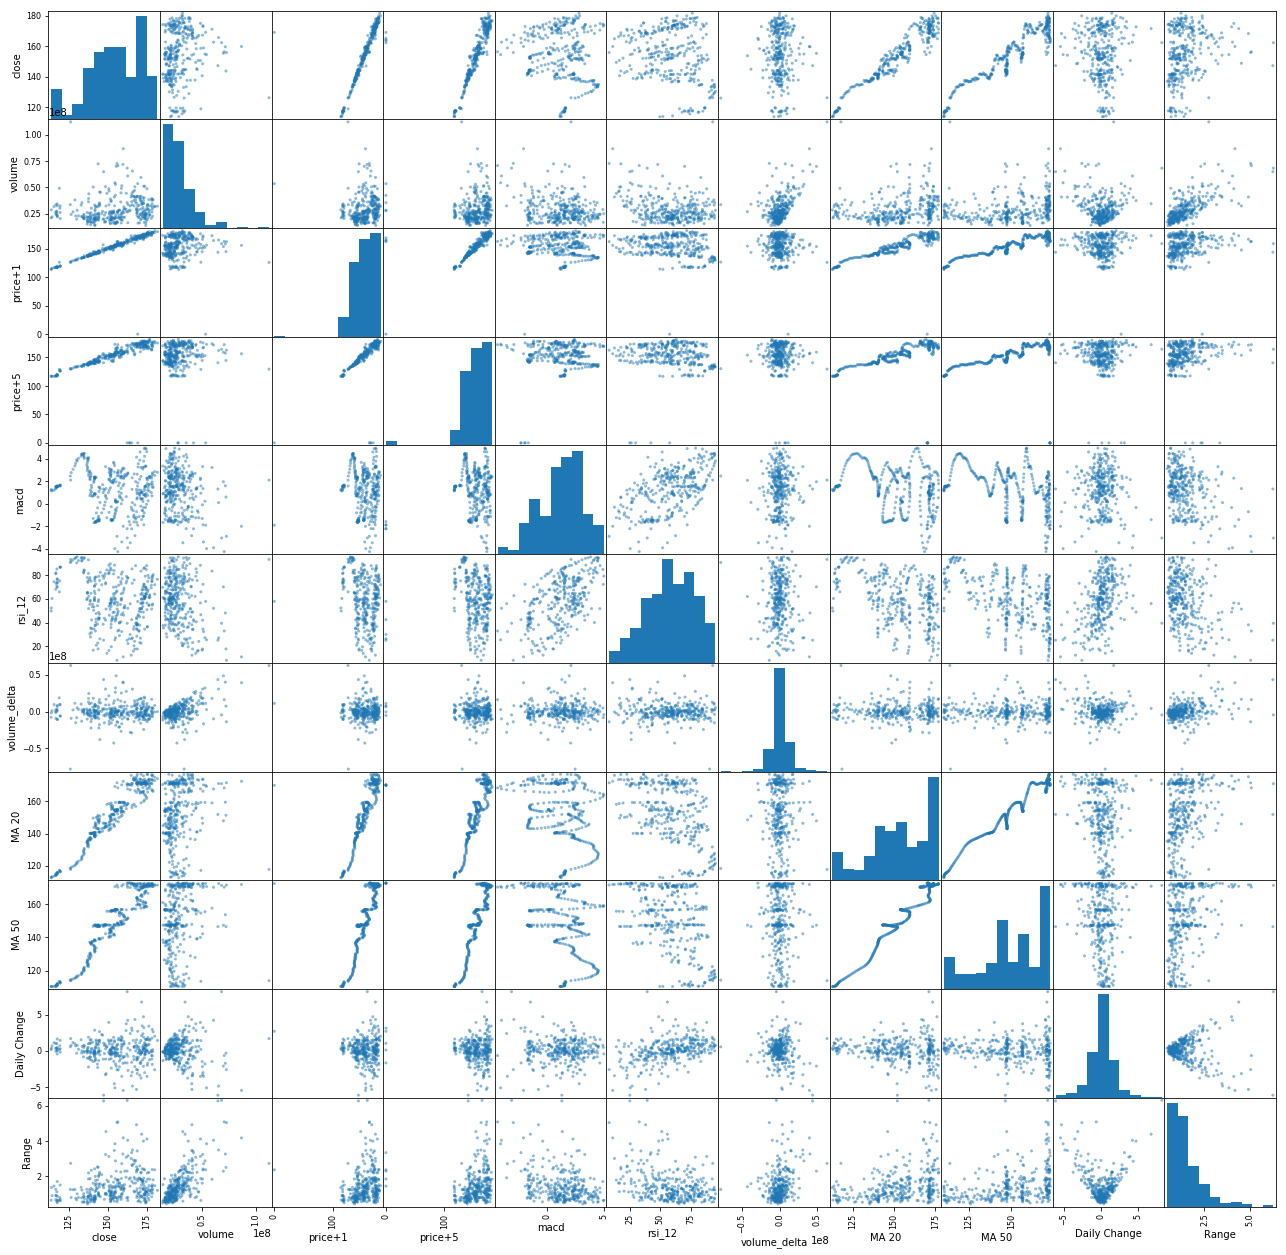

In [4]:
from pandas.plotting import scatter_matrix
scatter_matrix(X1,figsize=(22,22))
plt.show()

- As seen above, there does not seem to be much strongly related correlations for closing price and future prices except that of the moving average features. There are some weaker positive correlations such as volume correlating with final price and future prices. The MACD and RSI indicators also seen to have a weak positive correlation with price. Overall, this data mostly does not seem to follow any linear trend.

In [5]:
from sklearn.preprocessing import MinMaxScaler

def normalize_df(df):
    normalize_data = MinMaxScaler()
    for i in range(0,df.shape[1]):
        df.iloc[:,i] = normalize_data.fit_transform(df.iloc[:,i].values.reshape(-1,1))
    return df

def coeff_determination(y_true,y_pred):
    SS_res = np.sum((y_true-y_pred)**2)
    SS_tot = np.sum((y_true-np.mean(y_true))**2)
    return(np.abs(1-SS_res/(SS_tot+1e-18)))


def RMSE_calc(X_test,y_test,y_max,y_min,model):
    y_validation = model.predict(X_test)
    y_validation_scaled = np.ravel(np.array(y_validation)) #*(y_max-y_min)+y_min))
    y_actual_scaled = np.array(np.array(y_test)) #*(y_max-y_min)+y_min)
    RMSE = ((np.sum((y_validation_scaled-y_actual_scaled)**(2)))**(0.5))/y_test.shape[0]
    return RMSE

In [6]:
X2 = normalize_df(X1)
y_normal = X2['close']


X3 = X2.drop(['close','price+1','price+5'], axis = 1)
print(X3.shape)
X3.tail(10)

time_length = X3.shape[0]

D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


(334, 8)


## Test with LSTM Neural Network

In [7]:
window = 10 #prediction time-lag window
#load data for neural network
def load_data(stock,y,window):
    raw_data = stock.as_matrix()
    length = raw_data.shape[0]
    indicators = raw_data.shape[1]    
    prices = y.as_matrix()
    data = []

    for index in range(len(raw_data)-(window)+1):
        data.append(raw_data[index:index+window])
    
    data = np.array(data)
    valid_size = int(np.round(2/100*data.shape[0]))
    test_size = int(1)
    training_size = data.shape[0] - (valid_size + test_size)
    
    X_train = data[:training_size+valid_size,:-1]
    y_train = prices[window-1:training_size+window+valid_size-1]
    
    #validation for time series
    X_valid = data[training_size:training_size+valid_size,:-1]
    y_valid = prices[training_size+window-1:training_size+valid_size+window-1]
    
    #X_valid = data[training_size+valid_size:,:-1]
    #y_valid = prices[-1]
    
    raw_data = raw_data.reshape(1,length,indicators)
    
    X_test = np.zeros((1,window,8))
    for i in range(0,window-1):
        X_test[0,window-1-i,:] = raw_data[0,length-i-1,:]
    X_test = X_test[:,1:,:]
    y_test = 0
    
    return [X_train, y_train, X_valid, y_valid, X_test, y_test]

In [8]:
#split into test-train-validation datasets
X_train, y_train, X_valid, y_valid, X_test, y_test = load_data(X3,y_normal,window+1)
print(X_valid.shape)
print(X_test)

(6, 10, 8)
[[[ 0.06868086  0.57016102  0.72616669  0.51342978  0.91143289  0.98863706
    0.43121081  0.11194523]
  [ 0.21215265  0.55065561  0.41511658  0.65454245  0.91262218  0.9919809
    0.27881974  0.19442692]
  [ 0.52537081  0.47300862  0.21647941  0.77242302  0.91018919  0.99416947
    0.0883309   0.52102397]
  [ 0.22957512  0.40788456  0.20692284  0.34949262  0.91042238  0.99760562
    0.31763053  0.21886748]
  [ 0.20075206  0.33754333  0.16166295  0.53489208  0.90278139  0.9996987
    0.23827532  0.46491524]
  [ 0.14654604  0.28999856  0.20874143  0.51726486  0.89913579  1.
    0.50111497  0.24077915]
  [ 0.142268    0.25964295  0.24962867  0.5519374   0.89737906  0.99996154
    0.4361041   0.17117035]
  [ 0.22079958  0.22169742  0.19390191  0.60944464  0.89313493  0.99834284
    0.31167469  0.31742709]
  [ 0.28992675  0.22017756  0.39297153  0.60291374  0.89203114  0.99586512
    0.64789973  0.4954774 ]
  [ 0.40366846  0.25501237  0.56902219  0.63389636  0.89258304  0.994797

In [9]:
#build LSTM model using keras
from keras.models import Sequential
from keras import regularizers
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model

def build_model(layers,neurons,d):
    #d = 0.3
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))   
    #used small L2 regularization here because it makes k folds CV more consistent
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))  
    
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

model = build_model([X3.shape[1],window,1],[256,256,32,1],0.3)

Compilation Time :  0.012031316757202148


In [ ]:
#find optimal number of epochs to run for neural network
epochs = [30,45,50,60,80,90,100,120]
RMSE_all = []
model = build_model([X3.shape[1],window,1],[256,256,32,1],0.3)

for epoch in epochs:
    model.fit(X_train,y_train,batch_size=512,epochs=epoch,validation_split=0.1,verbose=1)
    y_validation = model.predict(X_valid)
    RMSE = RMSE_calc(X_valid,y_valid,y_max,y_min,model)
    RMSE_all.append(RMSE)

#removed output to save space

[0.023308829707623182, 0.049492606252843713, 0.053641881351442662, 0.041094340971933138, 0.036246898538482959, 0.033584189566060116, 0.02663518058577671, 0.020870150249515749]


Text(0,0.5,'RMSE')

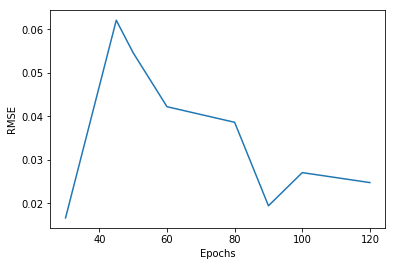

In [11]:
print(RMSE_all)

plt.plot(epochs,RMSE_all)
plt.xlabel("Epochs")
plt.ylabel("RMSE")


- As seen above, the best amount of epochs for this model is 120, but there is a decrease in RMSE at 90 epochs compared to 80 or 100. Additionally, having more epochs increases the computation time for the neural network, so having a low amount of epochs is good especially for a lightweight web app. Therefore, 90 epochs is chosen as the best amount due to having a lower computation time and good RMSE, and will be used for the rest of the models run in this notebook and in the web app. It is noted that regardless of whether the first choice is 30, 45 or 50, the RMSE always seems to be the lowest during the first run. Therefore, it can be considered an outlier and ignored.

In [12]:
model = build_model([X3.shape[1],window,1],[256,256,32,1],0.3)
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Compilation Time :  0.014037132263183594
Train on 290 samples, validate on 33 samples
Epoch 1/90
290/290 [==============================] - 0s 2ms/step - loss: 0.4003 - acc: 0.0000e+00 - val_loss: 0.6924 - val_acc: 0.0000e+00
Epoch 2/90
290/290 [==============================] - 0s 131us/step - loss: 0.3908 - acc: 0.0000e+00 - val_loss: 0.6724 - val_acc: 0.0000e+00
Epoch 3/90
290/290 [==============================] - 0s 131us/step - loss: 0.3780 - acc: 0.0000e+00 - val_loss: 0.6426 - val_acc: 0.0000e+00
Epoch 4/90
290/290 [==============================] - 0s 124us/step - loss: 0.3583 - acc: 0.0000e+00 - val_loss: 0.5932 - val_acc: 0.0000e+00
Epoch 5/90
290/290 [==============================] - 0s 128us/step - loss: 0.3276 - acc: 0.0000e+00 - val_loss: 0.5129 - val_acc: 0.0000e+00
Epoch 6/90
290/290 [==============================] - 0s 130us/step - loss: 0.2790 - acc: 0.0000e+00 - val_loss: 0.3908 - val_acc: 0.0000e+00
Epoch 7/90
290/290 [==============================] - 0s 128us/s

290/290 [==============================] - 0s 114us/step - loss: 0.0101 - acc: 0.0034 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 60/90
290/290 [==============================] - 0s 116us/step - loss: 0.0094 - acc: 0.0034 - val_loss: 0.0055 - val_acc: 0.0000e+00
Epoch 61/90
290/290 [==============================] - 0s 116us/step - loss: 0.0090 - acc: 0.0034 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 62/90
290/290 [==============================] - 0s 114us/step - loss: 0.0085 - acc: 0.0034 - val_loss: 0.0058 - val_acc: 0.0000e+00
Epoch 63/90
290/290 [==============================] - 0s 119us/step - loss: 0.0080 - acc: 0.0034 - val_loss: 0.0067 - val_acc: 0.0000e+00
Epoch 64/90
290/290 [==============================] - 0s 116us/step - loss: 0.0078 - acc: 0.0034 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 65/90
290/290 [==============================] - 0s 116us/step - loss: 0.0075 - acc: 0.0034 - val_loss: 0.0102 - val_acc: 0.0000e+00
Epoch 66/90
290/290 [==================

In [13]:
y_validation = model.predict(X_valid)

y_validation_scaled = np.ravel(np.array(y_validation)) #*(y_max-y_min)+y_min))
y_actual_scaled = np.array(np.array(y[time_length-6:]))#*(y_max-y_min)+y_min)

RMSE = ((np.sum((y_validation_scaled-y_actual_scaled)**(2)))**(0.5))/(X_valid.shape[0])

print(y_validation_scaled)
print(y_actual_scaled)
print(RMSE)

R2 = coeff_determination(y_actual_scaled,y_validation_scaled) #inaccurate
print('R^2 =',R2)

[ 0.89583379  0.89785862  0.8976028   0.89479852  0.88955092  0.88049334]
[ 0.72382353  0.73426471  0.74264706  0.71470588  0.75794118  0.81441176]
0.0611198815116
R^2 = 19.9486402708


- $R^2$ calculated from the validation dataset shows that it is not a good indicator to show whether predicting future stock prices 1 day beforehand is accurate or not because it calculates a value above 1. The RMSE seems low for this model indicating it may be a good model to use for the web app.

- Next, a prediction will be made:

In [14]:
y_predict = model.predict(X_test)
y_predict_scaled = y_predict*(y_max-y_min)+y_min
print(y_predict_scaled)

#Decision based on prediction on data for tomorrow's price
y_check = y[-1]*(y_max-y_min)+y_min

print('Based on previous value of:', y_check)
if y_check < y_predict_scaled:
    print('Buy')
elif y_check > y_predict_scaled:
    print('Sell if bought')
else:
    print('error')

[[ 171.21844482]]
Based on previous value of: 169.1
Buy


In [15]:
#cross validation on 4 folds in time series
def load_data(stock,y,window):
    raw_data = stock.as_matrix()
    length = raw_data.shape[0]
    indicators = raw_data.shape[1]    
    prices = y.as_matrix()
    data = []

    for index in range(len(raw_data)-(window)+1):
        data.append(raw_data[index:index+window])
    
    data = np.array(data)
    valid_size = int(10)
    test_size = int(1)
    training_size = data.shape[0] - (valid_size + test_size)
    
    X_train = data[:training_size+valid_size,:-1]
    y_train = prices[window-1:training_size+window+valid_size-1]
    
    #validation for time series
    X_valid = data[training_size:training_size+valid_size,:-1]
    y_valid = prices[training_size+window-1:training_size+valid_size+window-1]
    
    #X_valid = data[training_size+valid_size:,:-1]
    #y_valid = prices[-1]
    
    raw_data = raw_data.reshape(1,length,indicators)
    
    X_test = np.zeros((1,window,8))
    for i in range(0,window-1):
        X_test[0,window-1-i,:] = raw_data[0,length-i-1,:]
    X_test = X_test[:,1:,:]
    y_test = 0
    
    return [X_train, y_train, X_valid, y_valid, X_test, y_test]

def time_series_test_train(X,y,length):
    #automatically choses CV length at 10
    CV = 10
    X_train = X[0:length,:,:]
    y_train = y[0:length]
    
    X_CV = X[length:length+10,:,:]
    y_CV = y[length:length+10]
    return [X_train, y_train, X_CV, y_CV]


model = build_model([X3.shape[1],window,1],[256,256,32,1],0.3)

Compilation Time :  0.013034343719482422


In [ ]:
X_train_CV, y_train_CV, X_valid, y_valid, X_test, y_test = load_data(X3,y_normal,window+1)
data_length = X_train.shape[0]
scores = []

[X_train1, y_train1, X_CV_1, y_CV_1] = time_series_test_train(X_train_CV,y_train_CV,(data_length-30))
model.fit(X_train1,y_train1,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_CV_1, y_CV_1, y_max, y_min, model)
scores.append(RMSE)

[X_train2, y_train2, X_CV_2, y_CV_2] = time_series_test_train(X_train_CV,y_train_CV,(data_length-20))
model.fit(X_train2,y_train2,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_CV_2, y_CV_2, y_max, y_min, model)
scores.append(RMSE)

[X_train3, y_train3, X_CV_3, y_CV_3] = time_series_test_train(X_train_CV,y_train_CV,(data_length-10))
model.fit(X_train3,y_train3,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_CV_3, y_CV_3, y_max, y_min, model)
scores.append(RMSE)

model.fit(X_train_CV,y_train_CV,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_valid, y_valid, y_max, y_min, model)
scores.append(RMSE)


#removed output to save space

[0.015943647104427076, 0.016854629710307507, 0.02287334925415997, 0.01925573363878303]
Mean RMSE: 0.0187318399269
Standard Deviation: 0.00267976218822


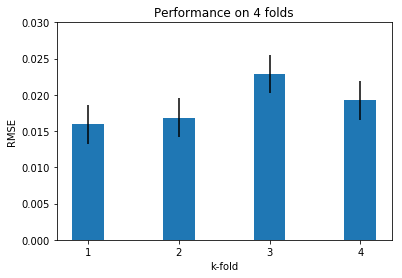

In [19]:
#shows 4-fold CV scores
print(scores)

print('Mean RMSE:', np.mean(scores))
print('Standard Deviation:', np.std(scores))
ind = np.arange(4)
width = 0.35
plt.ylim([0,0.03])
plt.xlabel('k-fold')
plt.ylabel('RMSE')
plt.title('Performance on 4 folds')
plt.bar(ind,scores, width, yerr=np.std(scores))
plt.xticks(ind,('1','2','3','4'))
plt.show()

- Overall, the RMSE for a 4-fold cross validation shows that the RMSE calculated for 10 validation data points to be similar to each other. 
- Next, the code will test for L2 regularization for 4 different values in order to find the best one based on RMSE score.

In [ ]:
def build_model_bestL1L2(layers,neurons,d,L1L2):
    #d = 0.3
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu', 
                    kernel_regularizer=regularizers.l2(L1L2),
                    activity_regularizer=regularizers.l2(L1L2)))   
    #used small L2 regularization here because it makes k folds CV more consistent
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear', 
                    kernel_regularizer=regularizers.l2(L1L2),
                    activity_regularizer=regularizers.l2(L1L2)))  
    
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

L1L2 = [0.000001, 0.00001, 0.0001, 0.001]
scores = []
for i in L1L2:
    model = build_model_bestL1L2([X3.shape[1],window,1],[256,256,32,1],0.3,i)
    [X_train1, y_train1, X_CV_1, y_CV_1] = time_series_test_train(X_train_CV,y_train_CV,(data_length-30))
    model.fit(X_train1,y_train1,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
    RMSE = RMSE_calc(X_CV_1, y_CV_1, y_max, y_min, model)
    scores.append(RMSE)

    [X_train2, y_train2, X_CV_2, y_CV_2] = time_series_test_train(X_train_CV,y_train_CV,(data_length-20))
    model.fit(X_train2,y_train2,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
    RMSE = RMSE_calc(X_CV_2, y_CV_2, y_max, y_min, model)
    scores.append(RMSE)

print(scores)    

#removed output to save space

[0.036340822157787216, 0.01673229794481917, 0.02081482773500432, 0.012177204797566898, 0.018883720257887517, 0.029551716786630138, 0.13542850180514404, 0.11031068725773811]
[0.02653656005130319, 0.016496016266285607, 0.024217718522258826, 0.12286959453144108]


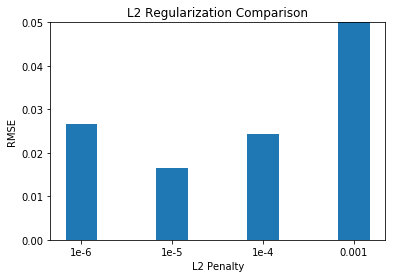

In [21]:
print(scores)
i1 = [0,2,4,6]

avg_scr = []
for i in i1:
    scr1 = (scores[i]+scores[i+1])/2
    avg_scr.append(scr1)

print(avg_scr)
plt.ylim([0,0.05])
plt.xlabel('L2 Penalty')
plt.ylabel('RMSE')
plt.title('L2 Regularization Comparison')
plt.bar(ind,avg_scr, width)
plt.xticks(ind,('1e-6','1e-5','1e-4','0.001'))
plt.show()

- It is shown that a L2 value of 0.00001 is the optimal value based on RMSE as it offers the most consistent results in a 2 fold CV. Additionally, it is noted that L2 is used instead of L1 because there are enough samples and only a relatively small amount of features in this model so a sparse solution is not necessary. However, compared with no regularization, the difference in RMSE is minimal, so L2 regularization is likely not needed.

In [22]:
#predict 5 days ahead of time

#adjust stock price
y_normal1 = y_normal[5:]
y_normal1.shape
y_normal1 = np.array(y_normal1)
y_normal2 = pd.DataFrame(np.append(y_normal1,[0,0,0,0,0]))
#y_normal2.head(10)

In [23]:
def load_data(stock,y,window):
    raw_data = stock.as_matrix()
    length = raw_data.shape[0]
    indicators = raw_data.shape[1]    
    prices = y.as_matrix()
    data = []

    for index in range(len(raw_data)-(window)+1):
        data.append(raw_data[index:index+window])
    
    data = np.array(data)
    valid_size = int(np.round(1/100*data.shape[0]))
    test_size = int(1)
    training_size = data.shape[0] - (4 + test_size)
    
    X_train = data[:training_size,:-1]
    y_train = prices[window-1:training_size+window-1]
    
    #no need
    #X_valid = data[training_size:training_size+valid_size,:-1]
    #y_valid = prices[training_size+window-1:training_size+valid_size+window-1]
    
    X_valid = data[training_size+valid_size:,:-1]
    y_valid = prices[-1]
    
    raw_data = raw_data.reshape(1,length,indicators)
    
    X_test = np.zeros((1,window,8))
    for i in range(0,window-1):
        X_test[0,window-1-i,:] = raw_data[0,length-i-1,:]
    X_test = X_test[:,1:,:]
    y_test = 0
    
    return [X_train, y_train, X_valid, y_valid, X_test, y_test]


X_train, y_train, X_valid, y_valid, X_test, y_test = load_data(X3,y_normal2,window+1)

In [ ]:
#Cross validation on 5 steps ahead time series
X_train_CV = X_train
y_train_CV = y_train
model = build_model([X3.shape[1],window,1],[256,256,32,1],0.3)

data_length = X3.shape[0]
scores = []

[X_train1, y_train1, X_CV_1, y_CV_1] = time_series_test_train(X_train_CV,y_train_CV,(data_length-46))
model.fit(X_train1,y_train1,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_CV_1, y_CV_1, y_max, y_min, model)
scores.append(RMSE)

[X_train2, y_train2, X_CV_2, y_CV_2] = time_series_test_train(X_train_CV,y_train_CV,(data_length-36))
model.fit(X_train2,y_train2,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_CV_2, y_CV_2, y_max, y_min, model)
scores.append(RMSE)

[X_train3, y_train3, X_CV_3, y_CV_3] = time_series_test_train(X_train_CV,y_train_CV,(data_length-26))
model.fit(X_train3,y_train3,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_CV_3, y_CV_3, y_max, y_min, model)
scores.append(RMSE)

[X_train4, y_train4, X_CV_4, y_CV_4] = time_series_test_train(X_train_CV,y_train_CV,(data_length-16))
model.fit(X_train3,y_train3,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_CV_4, y_CV_4, y_max, y_min, model)
scores.append(RMSE)

#removed output to save space

[0.12712396427628098, 0.05540716426255783, 0.05694203431486629, 0.02430791195701154]
Mean RMSE: 0.0659452687027
Standard Deviation: 0.0376450931181


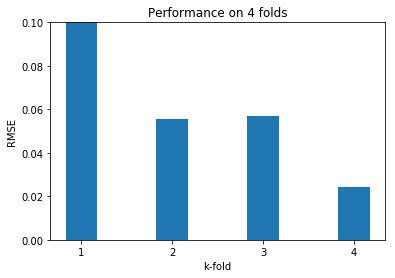

In [28]:
print(scores)

print('Mean RMSE:', np.mean(scores))
print('Standard Deviation:', np.std(scores))
ind = np.arange(4)
width = 0.35
plt.ylim([0,0.1])
plt.xlabel('k-fold')
plt.ylabel('RMSE')
plt.title('Performance on 4 folds')
plt.bar(ind,scores, width)
plt.xticks(ind,('1','2','3','4'))
plt.show()

- Overall, it is shown that this RMSE is greater than that of a 1 step forward model meaning the final predicted value may not be as accurate as that of the previous model, but the final fold has a similar RMSE to the previous model

In [33]:
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Train on 287 samples, validate on 32 samples
Epoch 1/90
287/287 [==============================] - 0s 133us/step - loss: 0.0031 - acc: 0.0035 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 2/90
287/287 [==============================] - 0s 133us/step - loss: 0.0034 - acc: 0.0035 - val_loss: 0.0093 - val_acc: 0.0000e+00
Epoch 3/90
287/287 [==============================] - 0s 126us/step - loss: 0.0030 - acc: 0.0035 - val_loss: 0.0094 - val_acc: 0.0000e+00
Epoch 4/90
287/287 [==============================] - 0s 122us/step - loss: 0.0031 - acc: 0.0035 - val_loss: 0.0104 - val_acc: 0.0000e+00
Epoch 5/90
287/287 [==============================] - 0s 119us/step - loss: 0.0031 - acc: 0.0035 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 6/90
287/287 [==============================] - 0s 126us/step - loss: 0.0030 - acc: 0.0035 - val_loss: 0.0084 - val_acc: 0.0000e+00
Epoch 7/90
287/287 [==============================] - 0s 126us/step - loss: 0.0028 - acc: 0.0035 - val_loss: 0.0089 - val_acc: 

Epoch 60/90
287/287 [==============================] - 0s 115us/step - loss: 0.0028 - acc: 0.0035 - val_loss: 0.0096 - val_acc: 0.0000e+00
Epoch 61/90
287/287 [==============================] - 0s 122us/step - loss: 0.0029 - acc: 0.0035 - val_loss: 0.0098 - val_acc: 0.0000e+00
Epoch 62/90
287/287 [==============================] - 0s 112us/step - loss: 0.0024 - acc: 0.0035 - val_loss: 0.0100 - val_acc: 0.0000e+00
Epoch 63/90
287/287 [==============================] - 0s 112us/step - loss: 0.0028 - acc: 0.0035 - val_loss: 0.0103 - val_acc: 0.0000e+00
Epoch 64/90
287/287 [==============================] - 0s 114us/step - loss: 0.0026 - acc: 0.0035 - val_loss: 0.0098 - val_acc: 0.0000e+00
Epoch 65/90
287/287 [==============================] - 0s 114us/step - loss: 0.0024 - acc: 0.0035 - val_loss: 0.0102 - val_acc: 0.0000e+00
Epoch 66/90
287/287 [==============================] - 0s 122us/step - loss: 0.0027 - acc: 0.0035 - val_loss: 0.0110 - val_acc: 0.0000e+00
Epoch 67/90
287/287 [======

In [35]:
y_predict = model.predict(X_test)
y_predict_scaled = y_predict*(y_max-y_min)+y_min
print(y_predict_scaled)

#Decision based on prediction for 5 future steps
y_check = y[-1]*(y_max-y_min)+y_min

print('Based on previous value of:', y_check)
if y_check < y_predict_scaled:
    print('Buy')
elif y_check > y_predict_scaled:
    print('Sell if bought')
else:
    print('error')

[[173.20153809]]
Based on previous value of: 169.1
Buy


- Based on the dataset, it can be shown that the 5 step forward prediction is pretty accurate. However, the cross validation results are not so good compared to a 1 step forward model. Unlike the random forests model, the answers make sense and are not much different than the actual price. Therefore, the forward predictions for 1 day and 5 days for this model will be used for the final web app. Because of the higher RMSE for this model in the cross validation steps compared to the previous one, a larger step prediction will result in much larger errors.

## Random Forests

In [36]:
X3.tail()

def RMSE_calc(y_validation,y_actual,length):
    y_validation_scaled = np.ravel(np.array(y_validation))
    y_actual_scaled = np.array(np.array(y_actual))
    RMSE = ((np.sum((y_validation_scaled-y_actual_scaled)**(2)))**(0.5))/length
    return RMSE

In [37]:
feature_list = list(X3.columns)
X3.describe()

,volume,macd,rsi_12,volume_delta,MA 20,MA 50,Daily Change,Fluctuation
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,0.156898,0.597408,0.579219,0.555396,0.627063,0.635781,0.433715,0.175806
std,0.126446,0.198884,0.226420,0.086318,0.269047,0.296193,0.115584,0.156009
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.073413,0.478864,0.411337,0.515587,0.444025,0.462754,0.385245,0.071389
50%,0.122278,0.622816,0.591512,0.551311,0.649234,0.652853,0.434301,0.133679
75%,0.200893,0.732714,0.761095,0.586107,0.900212,0.938257,0.493668,0.230271
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
X_train = X3.iloc[0:data_length-1,:]
X_test = np.matrix(X3.iloc[-1,:])

y_train = y_normal.iloc[1:]

0.0220150515719
6


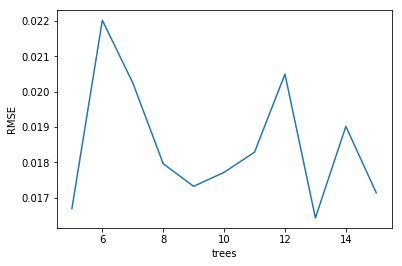

In [41]:
from sklearn.ensemble import RandomForestRegressor

trees = np.linspace(5,15,11)
trees = trees.astype(int)
#time series test train split
X_train1 = X_train.iloc[0:data_length-1-10,:]
X_test1 = X_train.iloc[data_length-1-10:,:]
y_train1 = y_train.iloc[0:data_length-1-10]
y_test1 = y_train.iloc[data_length-1-10:]

scores = []

for tree in trees:
    model = RandomForestRegressor(n_estimators=tree, criterion='mse', max_depth=7, 
                                  min_samples_split=2, min_samples_leaf=1, 
                                  max_features='auto', max_leaf_nodes=None, 
                                  bootstrap=True, oob_score=False, n_jobs=1, 
                                  random_state=None, verbose=0)
    model.fit(X_train1,y_train1)
    y_predict = model.predict(X_test1)
    #score = coeff_determination(y_test1,y_predict)
    score = RMSE_calc(y_predict,y_test1,10)
    scores.append(score)
    
plt.plot(trees,scores)
plt.xlabel('trees')
plt.ylabel('RMSE')
print(np.max(scores))
best_depth = trees[np.argmax(scores)]
print(best_depth)

In [42]:
#cross validate results
X_new = np.matrix(X_train)
y_new = y_train

model = RandomForestRegressor(n_estimators=12, criterion='mse', max_depth=7, 
                                  min_samples_split=2, min_samples_leaf=1, 
                                  max_features='log2', max_leaf_nodes=None, 
                                  bootstrap=True, oob_score=False, n_jobs=1, 
                                  random_state=None, verbose=0)

from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=30)
i = 0
scores = []
for train_index, test_index in tss.split(X_new):
    #print('Train:', train_index, 'Test:', test_index)
    i += 1
    if i >= 26 and i < 30:
        X_train, X_test = X_new[train_index,:], X_new[test_index,:]
        y_train, y_test = y_new[train_index], y_new[test_index]
        model.fit(X_train,y_train)
        y_predict = model.predict(X_test)
        score = RMSE_calc(y_predict,y_test,y_test.shape[0])
        scores.append(score)
print(scores)

[0.023665277387427297, 0.021554185095834948, 0.015553952718773486, 0.015682451198210663]


Mean RMSE: 0.0191139666001
Standard Deviation: 0.00357484590501


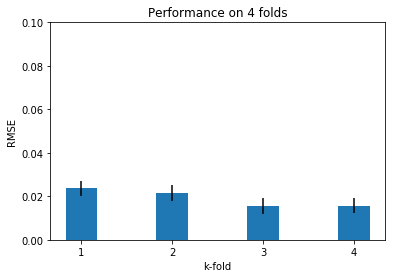

In [43]:
print('Mean RMSE:', np.mean(scores))
print('Standard Deviation:', np.std(scores))
ind = np.arange(4)
width = 0.35
plt.ylim([0,0.1])
plt.xlabel('k-fold')
plt.ylabel('RMSE')
plt.title('Performance on 4 folds')
plt.bar(ind,scores, width, yerr=np.std(scores))
plt.xticks(ind,('1','2','3','4'))
plt.show()

In [44]:
#try GridSearchCV
from sklearn.model_selection import GridSearchCV 
model = RandomForestRegressor()

param_grid = { 
    'n_estimators': [5,6,7,8,9,10,11,12,13,14,15,20,30,50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [None, 4,5,6,7,8]}

CV_rf = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
CV_rf.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 4, 5, 6, 7, 8], 'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 50], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
CV_rf.best_params_

{'max_depth': 7, 'max_features': 'auto', 'n_estimators': 12}

As seem above, the best features using GridSearchCV is the default features with 12 decision trees which is similar to what the RMSE vs trees plot shows above. As a result, 12 trees as n_estimators will be coded into the models below and above:

In [46]:
estimators = 12
max_depth=7
model = RandomForestRegressor(n_estimators=estimators, criterion='mse', max_depth=max_depth, 
                              min_samples_split=2, min_samples_leaf=2, 
                              max_features='auto', max_leaf_nodes=None, 
                              bootstrap=True, oob_score=False, n_jobs=1, 
                              random_state=None, verbose=0)
X_test = np.matrix(X3.iloc[-1,:])
model.fit(X_new,y_new)
y_predict = (model.predict(X_test))*((y_max-y_min)+y_min)
print(y_predict)

[ 162.73082379]


- Although the cross validation RMSE is similar to that of the RNN, the predicted answer is much lower and does not make much sense compared to the actual values from the original dataset and also from the output from the neural network. Additionally, it is shown that there is much more variance in this cross validation.

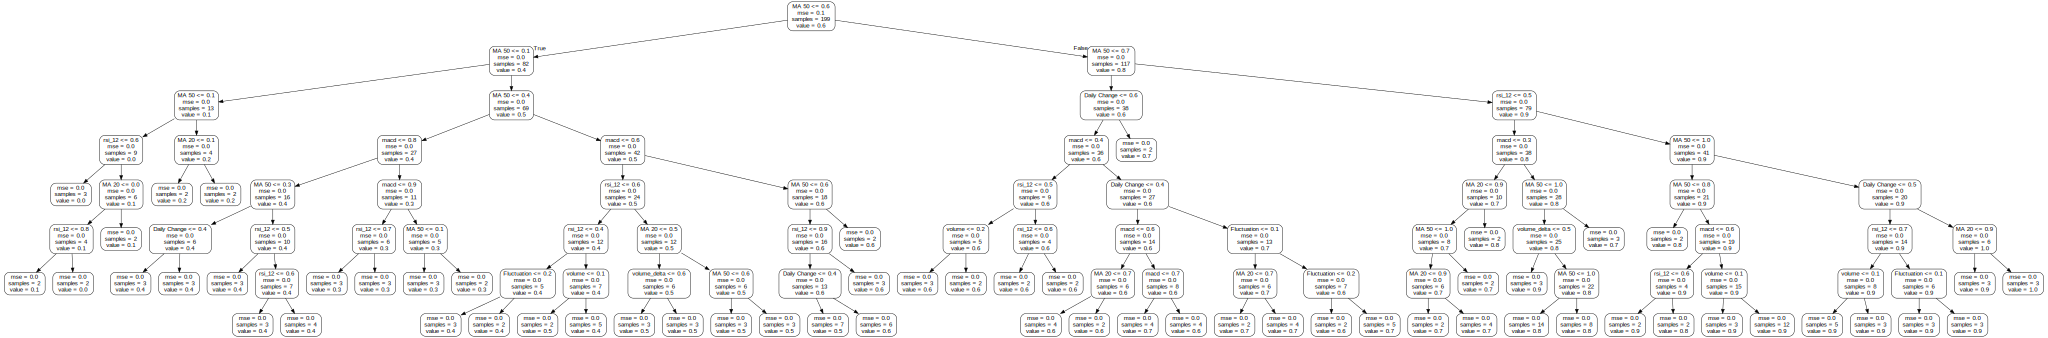

In [47]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
#import pydot
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image 
import graphviz
# Pull out one tree from the forest
tree = model.estimators_[5]
# Import tools needed for visualization
# Pull out one tree from the forest
tree = model.estimators_[5]
# Export the image to a dot file
dot_data = export_graphviz(tree, out_file = None, feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
graph = graphviz.Source(dot_data)
graph

In [48]:
#Decision based on prediction for 1 step forward
y_check = y[-1]*(y_max-y_min)+y_min

print('Based on previous value of:', y_check)
if y_check < y_predict:
    print('Buy')
elif y_check > y_predict:
    print('Sell if bought')
else:
    print('error')

Based on previous value of: 169.1
Sell if bought


In [51]:
#predict for 5 days ahead
X_train = X3.iloc[0:data_length-5,:]
X_test = np.matrix(X3.iloc[data_length-5:,:])
y_train = y_normal.iloc[5:]

In [62]:
X_new = np.matrix(X_train)
y_new = y_train

model = RandomForestRegressor(n_estimators=estimators, criterion='mse', max_depth=max_depth, 
                                  min_samples_split=2, min_samples_leaf=1, 
                                  max_features='auto', max_leaf_nodes=None, 
                                  bootstrap=True, oob_score=False, n_jobs=1, 
                                  random_state=None, verbose=0)

from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=25)
i = 0
scores = []
for train_index, test_index in tss.split(X_new):
    #print('Train:', train_index, 'Test:', test_index)
    i += 1
    if i >= 21 and i < 25:
        X_train, X_test = X_new[train_index,:], X_new[test_index,:]
        y_train, y_test = y_new[train_index], y_new[test_index]
        model.fit(X_train,y_train)
        y_predict = model.predict(X_test)
        score = RMSE_calc(y_predict,y_test,y_test.shape[0])
        scores.append(score)


[0.021479971200131846, 0.04964044505745937, 0.021985429512531816, 0.025353762850489694]
Mean RMSE: 0.0296149021552
Standard Deviation: 0.0116572470073


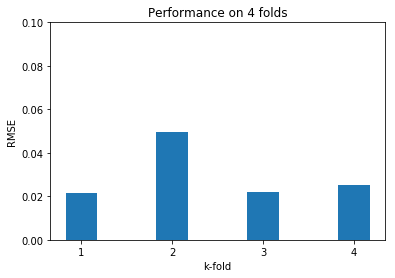

In [63]:
print(scores)

print('Mean RMSE:', np.mean(scores))
print('Standard Deviation:', np.std(scores))
ind = np.arange(4)
width = 0.35
plt.ylim([0,0.1])
plt.xlabel('k-fold')
plt.ylabel('RMSE')
plt.title('Performance on 4 folds')
plt.bar(ind,scores, width)
plt.xticks(ind,('1','2','3','4'))
plt.show()

In [67]:
model = RandomForestRegressor(n_estimators=best_depth, criterion='mse', max_depth=None, 
                              min_samples_split=2, min_samples_leaf=2, 
                              max_features='auto', max_leaf_nodes=None, 
                              bootstrap=True, oob_score=False, n_jobs=1, 
                              random_state=None, verbose=0)
X_test = np.matrix(X3.iloc[data_length-5:,:])
model.fit(X_new,y_new)
y_predict = (model.predict(X_test))*((y_max-y_min)+y_min)
print(y_predict[-1])

152.590944665


- Although it is shown that the RMSE is lower than that of the neural network, the random forests model maybe overfit the data because the values outputted do not match the original dataset very well. Therefore, this model cannot be used for the final web app because all of the values outputted give a lower price relative to the last price in the dataset

## ARIMA Model

In [68]:
y_normal.head() #ARIMA model only takes 1 input

date
2017-01-03    0.001874
2017-01-04    0.000000
2017-01-05    0.008504
2017-01-06    0.027243
2017-01-09    0.042810
Name: close, dtype: float64

In [69]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

def evaluate_arima_model(X,order):
    train_size = int(len(X)*0.9)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history,order=order)
        model_fit = model.fit(disp=0)
        y_pred = model_fit.forecast()[0]
        predictions.append(y_pred)
        history.append(test[t])
    error = mean_squared_error(test,predictions)
    return error


def evaluate_models(X,p_values,d_values,q_values):
    dataset = X.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset,order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA %s MSe=%.3f' %(order,mse))
                except:
                    continue
    print('Best ARIMA:%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg, best_score

p_values = [1, 2, 3]
d_values = range(0, 3)
q_values = range(0, 3)

In [70]:
best_cfg, best_score = evaluate_models(y_normal, p_values, d_values, q_values)
#takes long time to run, only ran once previously and used results in subsequent models:
import warnings
warnings.filterwarnings("ignore")


ARIMA (1, 0, 0) MSe=0.002
ARIMA (1, 0, 1) MSe=0.002
ARIMA (1, 0, 2) MSe=0.002
ARIMA (1, 1, 0) MSe=0.002
ARIMA (1, 2, 0) MSe=0.003
ARIMA (1, 2, 1) MSe=0.002
ARIMA (2, 0, 0) MSe=0.002
ARIMA (2, 0, 1) MSe=0.002
ARIMA (2, 0, 2) MSe=0.002
ARIMA (2, 1, 0) MSe=0.002
ARIMA (2, 1, 1) MSe=0.002
ARIMA (2, 2, 0) MSe=0.003
ARIMA (2, 2, 1) MSe=0.002
ARIMA (2, 2, 2) MSe=0.002
ARIMA (3, 0, 0) MSe=0.002
ARIMA (3, 0, 1) MSe=0.002
ARIMA (3, 0, 2) MSe=0.002
ARIMA (3, 1, 0) MSe=0.002
ARIMA (3, 1, 1) MSe=0.002
ARIMA (3, 1, 2) MSe=0.002
ARIMA (3, 2, 0) MSe=0.002
ARIMA (3, 2, 2) MSe=0.002
Best ARIMA:(3, 1, 2) MSE=0.002


Output from previous cell:
Best ARIMA:(3, 1, 2) MSE=0.002

In [73]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def coeff_determination(y_true,y_pred):
    SS_res = np.sum((y_true-y_pred)**2)
    SS_tot = np.sum((y_true-np.mean(y_true))**2)
    return(np.abs(1-SS_res/(SS_tot+1e-18)))

Day 1: 0.895951


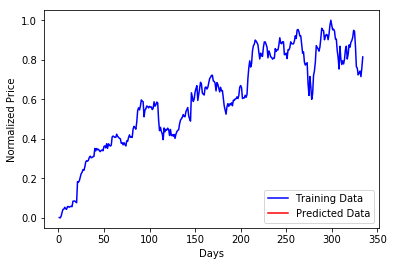

In [74]:
series = y_normal
# seasonal difference
X = series.values
days_in_year = 52 #rough timeframe per season
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(3,1,2)) #from results of Best ARMIA coefficients
model_fit = model.fit(disp=0)

future_steps = 1
# multistep future forecast
forecast = model_fit.forecast(steps=future_steps)[0]
# invert the differenced forecast to something usable
y_predict = [x for x in X]
day = 1

for yhat in forecast:
    inverted = inverse_difference(y_predict, yhat, days_in_year)
    print('Day %d: %f' % (day, inverted))
    y_predict.append(inverted)
    day += 1

y_predict = np.array(y_predict)
plt.figure()
days = np.linspace(1,y_predict.shape[0],y_predict.shape[0])
pred_len = y_predict.shape[0]
plt.plot(days[0:pred_len-future_steps],y_predict[0:pred_len-future_steps],color='b', label='Training Data')
plt.plot(days[pred_len-future_steps:],y_predict[pred_len-future_steps:],color='r', label='Predicted Data')
plt.xlabel('Days')
plt.ylabel('Normalized Price')
plt.legend(loc="lower right")

In [75]:
y_predict_scaled = y_predict[-1]*(y_max-y_min)+y_min
print(y_predict_scaled)

#Decision based on prediction for 1 day in future
y_check = y_normal[-1]*(y_max-y_min)+y_min

print('Based on previous value of:', y_check)
if y_check < y_predict_scaled:
    print('Buy')
elif y_check > y_predict_scaled:
    print('Sell if bought')
else:
    print('error')

174.644665477
Based on previous value of: 169.1
Buy


In [76]:
time_length = y_normal.shape[0]

def time_series_test_train(X,length):
    #automatically choses CV length at 10
    CV = 10
    X_train = X[0:length]
    X_CV = X[length:length+10]
    return [X_train, X_CV]

def RMSE_calc(X_train,X_CV,length,forward_steps):
    X = X_train.values
    days_in_year = 52
    differenced = difference(X, days_in_year)
    # fit model
    model = ARIMA(differenced, order=(3,1,2))
    model_fit = model.fit(disp=0)
    future_steps = forward_steps
    forecast = model_fit.forecast(steps=future_steps)[0]
    y_predict = [x for x in X]
    day = 1
    
    for yhat in forecast:
        inverted = inverse_difference(y_predict, yhat, days_in_year)
        y_predict.append(inverted)
        day += 1

    y_predict = np.array(y_predict)
    y_validation = y_predict[length:]
    y_validation_scaled = np.ravel(np.array(y_validation))
    y_actual_scaled = np.array(np.array(X_CV))
    RMSE = ((np.sum((y_validation_scaled-y_actual_scaled)**(2)))**(0.5))/10
    return RMSE

In [77]:
#Cross validation on time series for 4 folds
scores = []
X_train1, X_CV1 = time_series_test_train(y_normal,time_length-40)
RMSE1 = RMSE_calc(X_train1,X_CV1,time_length-40,1)
scores.append(RMSE1)

X_train2, X_CV2 = time_series_test_train(y_normal,time_length-30)
RMSE2 = RMSE_calc(X_train2,X_CV2,time_length-30,1)
scores.append(RMSE2)

X_train3, X_CV3 = time_series_test_train(y_normal,time_length-20)
RMSE3 = RMSE_calc(X_train3,X_CV3,time_length-20,1)
scores.append(RMSE3)
X_train4, X_CV4 = time_series_test_train(y_normal,time_length-10)
RMSE4 = RMSE_calc(X_train4,X_CV4,time_length-10,1)
scores.append(RMSE4)

[0.012389437810808802, 0.0296013810467869, 0.023719430967621309, 0.062661853583197508]
Mean RMSE: 0.0320930258521
Standard Deviation: 0.0187016710195


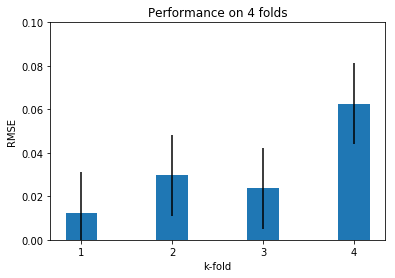

In [78]:
print(scores)

print('Mean RMSE:', np.mean(scores))
print('Standard Deviation:', np.std(scores))
ind = np.arange(4)
width = 0.35
plt.ylim([0,0.1])
plt.xlabel('k-fold')
plt.ylabel('RMSE')
plt.title('Performance on 4 folds')
plt.bar(ind,scores, width, yerr=np.std(scores))
plt.xticks(ind,('1','2','3','4'))
plt.show()

- Overall, the cross validation shows that for a 1 step model, the RMSE gets worse as the time series progresses and the variance seems high. The RMSE is somewhat higher to that of the RNN LTSM model. Furthermore, the ARIMA model cannot account for additional features that can be mathmatically derived from the stock prices initial dataset. 

Day 1: 0.895951
Day 2: 0.866812
Day 3: 0.840062
Day 4: 0.829203
Day 5: 0.863239


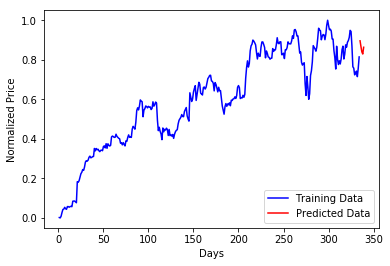

In [79]:
#try 5 days forward
series = y_normal
# seasonal difference
X = series.values
days_in_year = 52
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(3,1,2))
model_fit = model.fit(disp=0)

future_steps = 5
# multistep future forecast
forecast = model_fit.forecast(steps=future_steps)[0]
# invert the differenced forecast to something usable
y_predict = [x for x in X]
day = 1

for yhat in forecast:
    inverted = inverse_difference(y_predict, yhat, days_in_year)
    print('Day %d: %f' % (day, inverted))
    y_predict.append(inverted)
    day += 1

y_predict = np.array(y_predict)
plt.figure()
days = np.linspace(1,y_predict.shape[0],y_predict.shape[0])
pred_len = y_predict.shape[0]
plt.plot(days[0:pred_len-future_steps],y_predict[0:pred_len-future_steps],color='b',label='Training Data')
plt.plot(days[pred_len-future_steps:],y_predict[pred_len-future_steps:],color='r',label='Predicted Data')
plt.xlabel('Days')
plt.ylabel('Normalized Price')
plt.legend(loc="lower right")

In [81]:
y_predict_scaled = y_predict[-1]*(y_max-y_min)+y_min
print(y_predict_scaled)

#Decision based on prediction for 5 days in future
y_check = y_normal[-1]*(y_max-y_min)+y_min

print('Based on previous value of:', y_check)
if y_check < y_predict_scaled:
    print('Buy')
elif y_check > y_predict_scaled:
    print('Sell if bought')
else:
    print('error')

172.420250077
Based on previous value of: 169.1
Buy


In [83]:
scores = []
X_train1, X_CV1 = time_series_test_train(y_normal,time_length-45)
RMSE1 = RMSE_calc(X_train1,X_CV1,time_length-50,5)
scores.append(RMSE1)

X_train2, X_CV2 = time_series_test_train(y_normal,time_length-35)
RMSE2 = RMSE_calc(X_train2,X_CV2,time_length-40,5)
scores.append(RMSE2)

X_train3, X_CV3 = time_series_test_train(y_normal,time_length-25)
RMSE3 = RMSE_calc(X_train3,X_CV3,time_length-30,5)
scores.append(RMSE3)

X_train4, X_CV4 = time_series_test_train(y_normal,time_length-15)
RMSE4 = RMSE_calc(X_train4,X_CV4,time_length-20,5)
scores.append(RMSE4)

[0.018678453157679246, 0.026603640970902738, 0.01811221954730026, 0.019762515678574226]
Mean RMSE: 0.0207892073386
Standard Deviation: 0.00340893242366


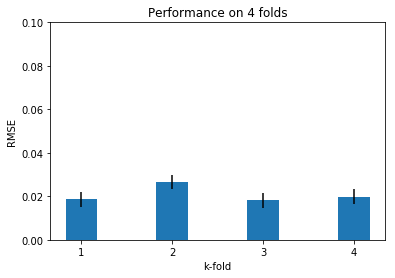

In [84]:
print(scores)
print('Mean RMSE:', np.mean(scores))
print('Standard Deviation:', np.std(scores))
ind = np.arange(4)
width = 0.35
plt.ylim([0,0.1])
plt.xlabel('k-fold')
plt.ylabel('RMSE')
plt.title('Performance on 4 folds')
plt.bar(ind,scores, width, yerr=np.std(scores))
plt.xticks(ind,('1','2','3','4'))
plt.show()

- The RMSE for this model for a 5 step prediction is much lower and more consistent than that of the 1 step prediction. However, the final prediction results is very similar to the LSTM model, so the LSTM model will be used for 1 day and 5 day predictions on the web app because there is no easy way to change the parameters of the ARIMA model

174.097563051
Based on previous value of: 169.1
Buy


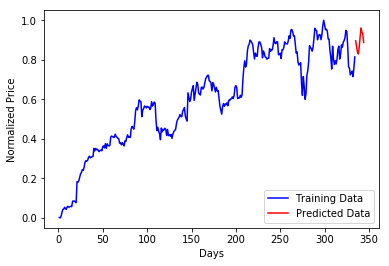

In [87]:
#try 10 days forward
series = y_normal
# seasonal difference
X = series.values
days_in_year = 52
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(3,1,2))
model_fit = model.fit(disp=0)

future_steps = 10
# multistep future forecast
forecast = model_fit.forecast(steps=future_steps)[0]
# invert the differenced forecast to something usable
y_predict = [x for x in X]
day = 1

for yhat in forecast:
    inverted = inverse_difference(y_predict, yhat, days_in_year)
    #print('Day %d: %f' % (day, inverted))
    y_predict.append(inverted)
    day += 1

y_predict = np.array(y_predict)
plt.figure()
days = np.linspace(1,y_predict.shape[0],y_predict.shape[0])
pred_len = y_predict.shape[0]
plt.plot(days[0:pred_len-future_steps],y_predict[0:pred_len-future_steps],color='b', label='Training Data')
plt.plot(days[pred_len-future_steps:],y_predict[pred_len-future_steps:],color='r',label='Predicted Data')
plt.xlabel('Days')
plt.ylabel('Normalized Price')
plt.legend(loc="lower right")

y_predict_scaled = y_predict[-1]*(y_max-y_min)+y_min
print(y_predict_scaled)

#Decision based on prediction for 10 days in future
y_check = y_normal[-1]*(y_max-y_min)+y_min

print('Based on previous value of:', y_check)
if y_check < y_predict_scaled:
    print('Buy')
elif y_check > y_predict_scaled:
    print('Sell if bought')
else:
    print('error')

In [89]:
#cross validation for 10 steps
scores = []
X_train1, X_CV1 = time_series_test_train(y_normal,time_length-45)
RMSE1 = RMSE_calc(X_train1,X_CV1,time_length-45,10)
scores.append(RMSE1)

X_train2, X_CV2 = time_series_test_train(y_normal,time_length-35)
RMSE2 = RMSE_calc(X_train2,X_CV2,time_length-35,10)
scores.append(RMSE2)

X_train3, X_CV3 = time_series_test_train(y_normal,time_length-25)
RMSE3 = RMSE_calc(X_train3,X_CV3,time_length-25,10)
scores.append(RMSE3)

X_train4, X_CV4 = time_series_test_train(y_normal,time_length-15)
RMSE4 = RMSE_calc(X_train4,X_CV4,time_length-15,10)
scores.append(RMSE4)

[0.023339998477167879, 0.034033993242853694, 0.02509195695278623, 0.043904283810994475]
Mean RMSE: 0.031592558121
Standard Deviation: 0.00818385225831


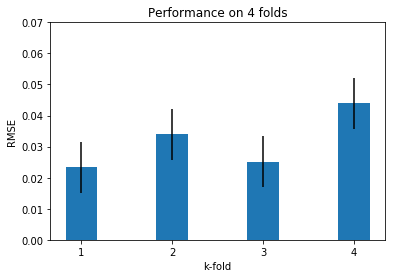

In [90]:
print(scores)
print('Mean RMSE:', np.mean(scores))
print('Standard Deviation:', np.std(scores))
ind = np.arange(4)
width = 0.35
plt.ylim([0,0.07])
plt.xlabel('k-fold')
plt.ylabel('RMSE')
plt.title('Performance on 4 folds')
plt.bar(ind,scores, width, yerr=np.std(scores))
plt.xticks(ind,('1','2','3','4'))
plt.show()

- As the time series progresses, the RMSE seems to increase in the 10 step prediction similar to the 1 step prediction. However, this model can be used for a long term prediction on the web app since the RMSE value is similar to that of the LSTM model, and the answer seems reasonable. In addition, the figures above show the forecasted stock values in red with the training data in blue. All of the 3 forecasts seem to follow the same pattern for this model.

### Web App:
http://kj2431.pythonanywhere.com/

or

http://35.196.7.153/

- User inputs NYSE stock ticker and will get 1-day, 5-day, and 10-day predictions as outputs